# Financial Analysis Project
### Group 3: Margarida Pereira, Sanjo Joy, Maine Isasi, Isaac Chaljub, Pablo Gallegos

## 1. Selecting a Financial Time Series Dataset

### Individual Company Stock Selected: Louis Vuitton, ticker "LVMHF".
#### Source: Yahoo Finance (yfinance library).
#### Period: Years 2015 - 2024
#### Goal: Given that Louis Vuitton is a luxury brand, it is expected to exhibit higher risk (volatility) compared to companies that produce essential goods. To assess this, we will conduct a comparative analysis through variance modeling using time series models.

In [13]:
#import yfinance as yf
import pandas as pd


#louis_vuitton = yf.download("LVMHF", start="2015-01-01", end="2024-12-31")

#lv = louis_vuitton['Close']


In [1]:
#lv = louis_vuitton.copy()
#lv = lv.reset_index(drop=False)
#lv.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
#lv= lv.set_index('Date')

#lv = lv['Close']

#lv.to_csv('LVMHF_2015_2024.csv')

In [2]:
import pandas as pd

lv = pd.read_csv('LVMHF_2015_2024.csv', parse_dates=True, index_col=0)

lv.head()

,Close
Date,
2015-01-02,134.303635
2015-01-05,129.202744
2015-01-06,126.588646
2015-01-07,125.884178
2015-01-08,129.363998


## 2. Exploratory Data Analysis (EDA)


### Plot the raw time series and discuss volatility clustering.

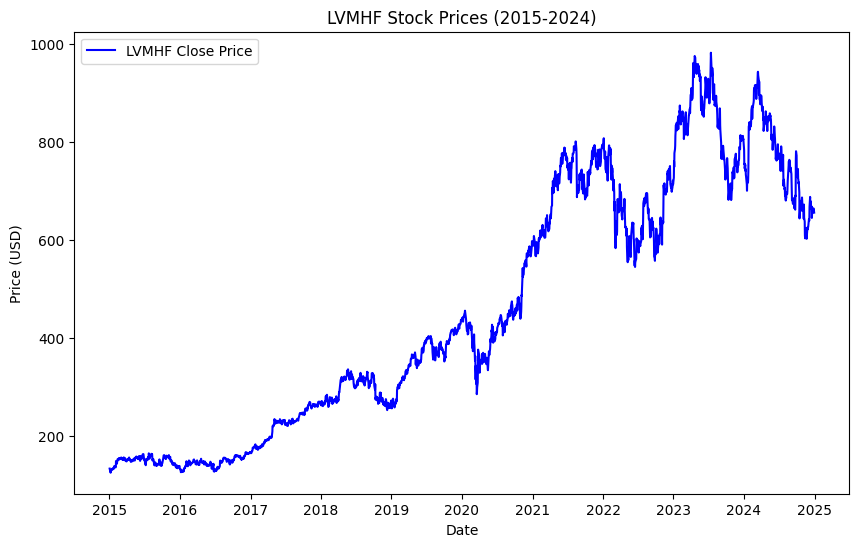

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lv.index, lv['Close'], label='LVMHF Close Price', color='blue')
plt.title('LVMHF Stock Prices (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


##### The raw time series visually shows volatility clustering as periods of high variance are followed by more variance, and the same for periods of low variance.

### Compute and analyze log-returns of the time series.

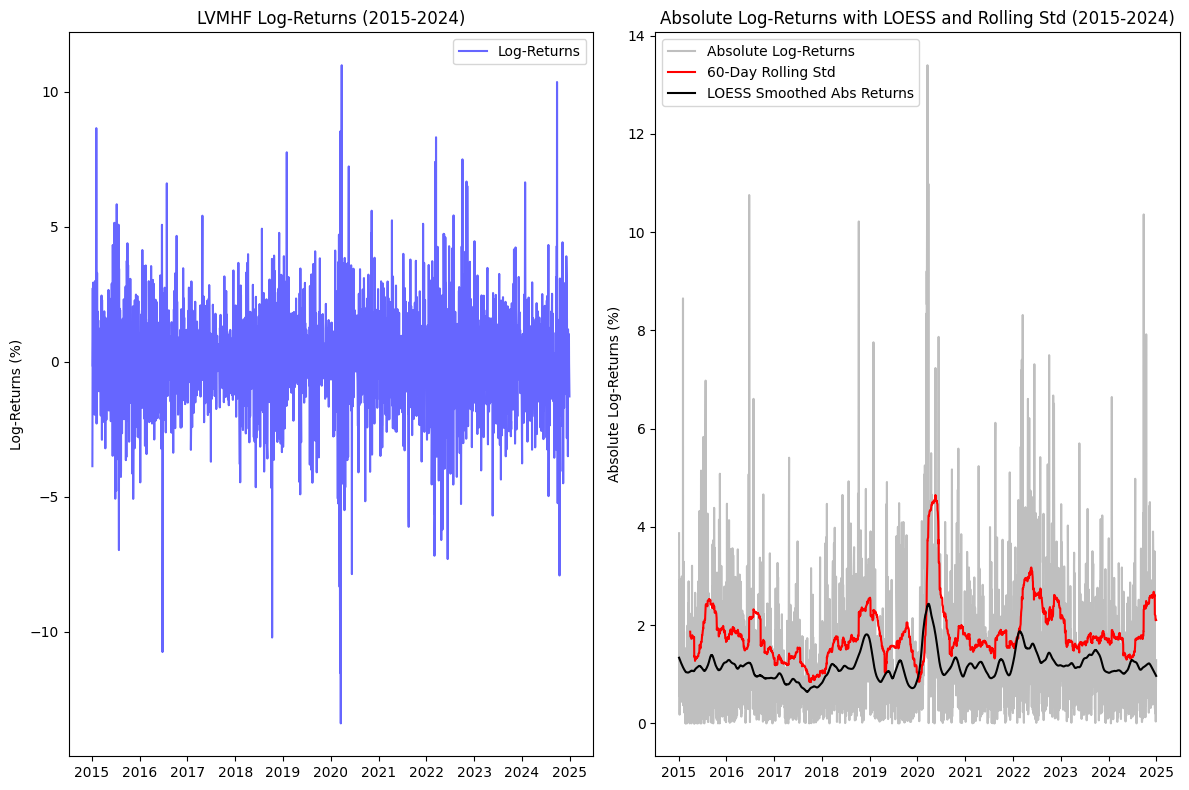

In [4]:
import numpy as np
import statsmodels.api as sm


# Compute percentage log-return
lv['Log_Return'] = np.log(lv['Close'] / lv['Close'].shift(1))*100
lv.dropna(inplace=True)

# Compute absolute log-returns
lv['Abs_Log_Return'] = np.abs(lv['Log_Return'])

# Compute rolling 60-day standard deviation
lv['Rolling_Std'] = lv['Log_Return'].rolling(window=60).std()

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(lv['Abs_Log_Return'], lv.index, frac=0.03)


# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

# Plot log-returns
top_ax = axes[0]
top_ax.plot(lv.index, lv['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
top_ax.set_ylabel("Log-Returns (%)")
top_ax.set_title("LVMHF Log-Returns (2015-2024)")
top_ax.legend()

# Plot absolute log-returns with LOESS and rolling std
bottom_ax = axes[1]
bottom_ax.plot(lv.index, lv['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
bottom_ax.plot(lv.index, lv['Rolling_Std'], color='red', label='60-Day Rolling Std')
bottom_ax.plot(lv.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
bottom_ax.set_ylabel("Absolute Log-Returns (%)")
bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2015-2024)")
bottom_ax.legend()

plt.tight_layout()
plt.show()

##### Log-Returns fluctuate around zero.<br /> Absolute Log-Returns show the (high) magnitude of price changes without considering the direction.<br /> Both 60-day Rolling Std Dev and LOESS Smoothed Abs Returns help to recognize periods of high or low volatility.

### Compute summary statistics and analyze stationarity of log-returns.

In [5]:
from statsmodels.tsa.stattools import adfuller

# Summary statistics
print("Log-Returns Summary Statistics:")
print(lv['Log_Return'].describe())
print(f"Skewness: {lv['Log_Return'].skew():.4f}")
print(f"Kurtosis: {lv['Log_Return'].kurtosis():.4f}")

# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(lv['Log_Return'])
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

Log-Returns Summary Statistics:
count    2514.000000
mean        0.063089
std         1.929046
min       -13.399838
25%        -0.983145
50%         0.085152
75%         1.112090
max        10.983622
Name: Log_Return, dtype: float64
Skewness: -0.2190
Kurtosis: 4.2939

ADF Test Results:
ADF Statistic: -17.5593
p-value: 0.0000


##### Mean is 0.059%, close to zero. <br /> Negative skewness indicates asymmetry in returns.<br /> Kurtosis 4.259 (higher than 3) suggest fatter tails than normal distribution (more likelihood of extreme events).<br /> ADF Test's p-value lower than 0.05 suggests log-returns stationarity (prerequisite for volatility modeling).

### Check autocorrelation and partial autocorrelation functions of log-returns.

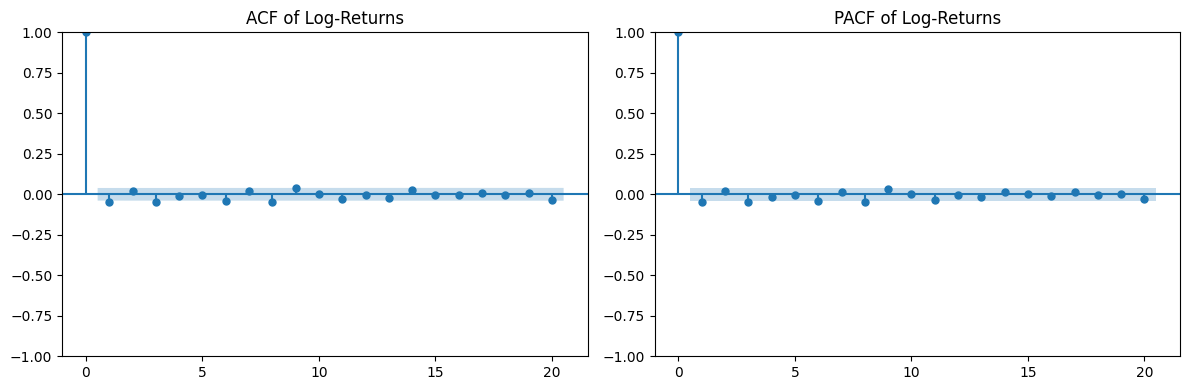

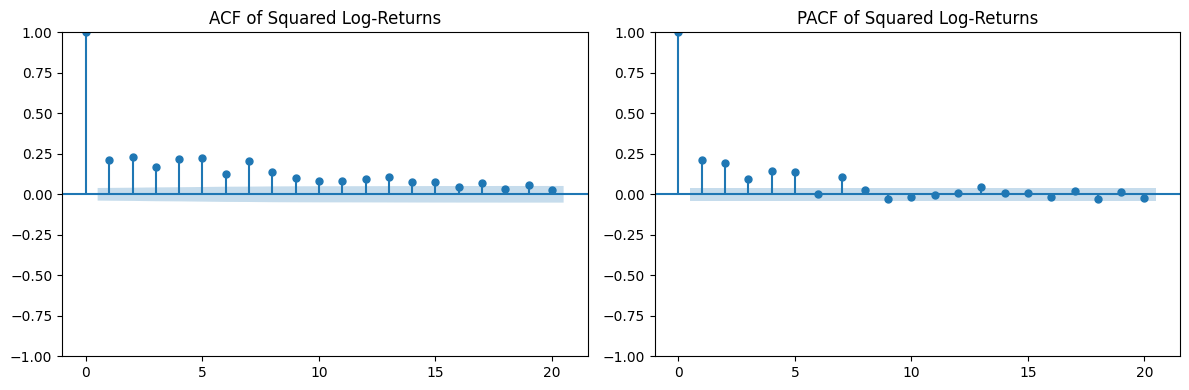

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for log-returns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(lv['Log_Return'], lags=20, ax=plt.gca())
plt.title('ACF of Log-Returns')
plt.subplot(1, 2, 2)
plot_pacf(lv['Log_Return'], lags=20, ax=plt.gca())
plt.title('PACF of Log-Returns')
plt.tight_layout()
plt.show()

# ACF and PACF for squared log-returns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(lv['Log_Return']**2, lags=20, ax=plt.gca())
plt.title('ACF of Squared Log-Returns')
plt.subplot(1, 2, 2)
plot_pacf(lv['Log_Return']**2, lags=20, ax=plt.gca())
plt.title('PACF of Squared Log-Returns')
plt.tight_layout()
plt.show()

##### ACF and PACF for log-returns: no autocorrelation is expected.<br /> ACF and PACF for squared log-returns: significant autocorrelation indicates volatility clustering, justifying the use of ARCH/GARCH models.


## 3. Volatility Modeling

### Fit various models (e.g., ARCH, GARCH, GJR-GARCH, EGARCH) to the log-returns.

In [7]:
from arch import arch_model

# Fit ARCH(1) model
arch_model = arch_model(lv['Log_Return'], vol='ARCH', p=1, mean='Zero', rescale=True)
arch_fit = arch_model.fit(disp='off')
print(arch_fit.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5138.36
Distribution:                  Normal   AIC:                           10280.7
Method:            Maximum Likelihood   BIC:                           10292.4
                                        No. Observations:                 2514
Date:                Sat, Mar 15 2025   Df Residuals:                     2514
Time:                        13:45:46   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.8786      0.163     17.714  3.274e-70 [  2.560,  3.19

In [8]:
from arch import arch_model

# Fit GARCH(1,1)
garch_model = arch_model(lv['Log_Return'], mean = 'Zero', vol='Garch', p=1, o=0, q=1, dist='t')
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4989.96
Distribution:      Standardized Student's t   AIC:                           9987.92
Method:                  Maximum Likelihood   BIC:                           10011.2
                                              No. Observations:                 2514
Date:                      Sat, Mar 15 2025   Df Residuals:                     2514
Time:                              13:45:46   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega     

In [9]:
# Fit GJR-GARCH(1,1,1)
GJR_garch_model = arch_model(lv['Log_Return'], vol='Garch', p=1, q=1, mean='zero', rescale=True)
GJR_garch_fit = GJR_garch_model.fit(disp='off')
print(GJR_garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5047.43
Distribution:                  Normal   AIC:                           10100.9
Method:            Maximum Likelihood   BIC:                           10118.4
                                        No. Observations:                 2514
Date:                Sat, Mar 15 2025   Df Residuals:                     2514
Time:                        13:45:47   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1397  6.231e-02      2.241  2.500e-02 [1.754e-0

In [10]:
# Fit EGARCH(1,1)
egarch_model = arch_model(lv['Log_Return'], vol='EGarch', p=1, q=1, mean='zero', rescale=True)
egarch_fit = egarch_model.fit(disp='off')
print(egarch_fit.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5046.18
Distribution:                  Normal   AIC:                           10098.4
Method:            Maximum Likelihood   BIC:                           10115.9
                                        No. Observations:                 2514
Date:                Sat, Mar 15 2025   Df Residuals:                     2514
Time:                        13:45:47   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0485  2.001e-02      2.422  1.545e-02 [9.

### Justify model selection using statistical criteria (AIC, BIC, likelihood ratio tests).

In [11]:
# Fit multiple models
models = {
    'ARCH': arch_model(lv['Log_Return'], vol='ARCH', p=1, mean='Zero', rescale=True).fit(disp='off'),
    'GARCH': arch_model(lv['Log_Return'], vol='Garch', p=1, q=1, mean='Zero', rescale=True).fit(disp='off'),
    'GJR-GARCH': arch_model(lv['Log_Return'], vol='Garch', p=1, o=1, q=1, mean='Zero', rescale=True).fit(disp='off'),
    'EGARCH': arch_model(lv['Log_Return'], vol='EGarch', p=1, q=1, mean='Zero', rescale=True).fit(disp='off')
}

# Compare AIC and BIC
for name, fit in models.items():
    print(f"{name}: AIC = {fit.aic:.4f}, BIC = {fit.bic:.4f}")


ARCH: AIC = 10280.7258, BIC = 10292.3850
GARCH: AIC = 10100.8668, BIC = 10118.3557
GJR-GARCH: AIC = 10079.0724, BIC = 10102.3909
EGARCH: AIC = 10098.3617, BIC = 10115.8505


##### GJR-GARCH(1,1,1) has the lowest AIC and BIC

### Evaluate model diagnostics and residual behavior.

## 4. Risk Modeling and Interpretation

### Compute and interpret Value at Risk (VaR) at different confidence levels using log-returns.

### Estimate Expected Shortfall (Conditional VaR) and assess tail risk.


### Discuss financial implications of risk estimates.